# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [56]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
from fastai import *
from fastai.vision import *

In [58]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [59]:
# fastai version
__version__

'1.0.35.dev0'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [67]:
seq_df.to_csv('seq_df.csv')

## Data loading

In [72]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [73]:
#seq_df.drop('Unnamed: 0', axis=1, inplace=True)

In [74]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [75]:
# Preprocess y values

In [76]:
len(seq_df['Target'])

2000

In [77]:
targA = seq_df['Target'].values; targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [78]:
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [79]:
targ = [[a,b] for a, b in zip(targA, targB)]; targ[:4], '...', targ[-4:]#, len(targ)

([[0, 1], [0, 1], [0, 1], [1, 0]], '...', [[1, 0], [0, 1], [1, 0], [1, 0]])

In [80]:
seq_df['MultiTarget'] = targ

In [81]:
def joinarray(x):
    y = ';'.join((str(x[0]),str(x[1])))
    return y

In [82]:
seq_df['MultiTarget'] = seq_df['MultiTarget'].apply(joinarray)

In [83]:
seq_df.head()

,Sequences,Target,MultiTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,0;1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,0;1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,0;1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,1;0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,1;0


## Data encoding test (incorporated into "open_seq_image" function)

In [86]:
# setup class instance to encode the four different bases to integer values (1D)
int_enc = LabelEncoder()

In [87]:
# setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
one_hot_enc = OneHotEncoder(categories=[range(4)])

In [88]:
seq_enc = []

for s in seq:
    enc = int_enc.fit_transform(list(s)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    seq_enc.append(enc.toarray()) # export sparse matrix to np array

In [89]:
len(seq_enc)

2000

In [462]:
seq_enc[0].T, seq_enc[0].T.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

In [311]:
PIL.Image.fromarray(seq_enc[0].T.astype('uint8')*255).convert('P')

## fastai data setup for NN

In [176]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    #print('enc', enc, enc.shape)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    #print('x', x, x.shape)
    return cls(x)

In [177]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [178]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return cls(items=df[cols].values)

In [179]:
bs = 64

In [213]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        #.label_from_list(seq_df['Target'].values) # --> Two categories! AND WRONG LOSS FUNCTION!?
        #.label_from_list(targ) # --> MultiCategory
        #.label_from_list(seq_df['MultiTarget'], sep=';')
        .label_from_list(seq_df['Target'], sep=';')
        .databunch(bs=bs))

## Verify data setup

### Check data object

In [214]:
data

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (2000 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 1, MultiCategory 1]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Valid: LabelList
y: MultiCategoryList (2000 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 1, MultiCategory 1]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Test: None

In [215]:
# check classes
data.c, data.classes

(2, ['0', '1'])

In [216]:
data.train_dl.batch_size

64

### Check data points

In [217]:
i = 2
data.x[i]

In [218]:
data.y[i]

MultiCategory 0

In [219]:
i = 3
data.x[i]

In [220]:
data.y[i]

MultiCategory 1

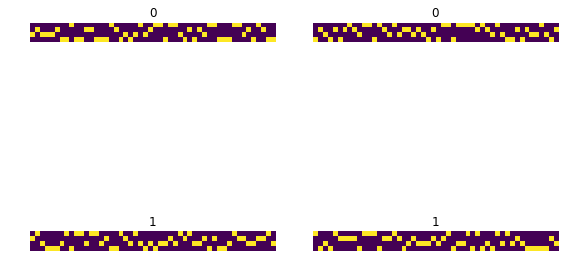

In [221]:
data.show_batch(rows=2)

# Model setup

## Setup fastai ResNet34 architecture

In [248]:
test_learn = create_cnn(data, models.resnet18)

In [249]:
test_learn.loss_func.func

BCEWithLogitsLoss()

In [143]:
#test_learn.model[0]

In [144]:
test_learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [145]:
def ExpandInput(): return Lambda(lambda x: x.expand(-1, 3, 4, 50))

In [146]:
EI = ExpandInput()

In [147]:
# Test ExpandInput layer

In [148]:
tt = torch.rand((64,1,4,50)); tt.shape

torch.Size([64, 1, 4, 50])

In [149]:
tt.expand(-1, 3, 4, 50).shape

torch.Size([64, 3, 4, 50])

In [150]:
Image(EI(tt)[0])

In [151]:
new_model = nn.Sequential(ExpandInput(), test_learn.model) # insert ExpandInput layer at the beginning of the network

In [152]:
new_model[0](tt).shape

torch.Size([64, 3, 4, 50])

In [157]:
new_learn = Learner(data, new_model)#, metrics=accuracy)

In [158]:
#[p.shape for p in new_model.parameters()]

In [159]:
new_learn.fit_one_cycle(5)

epoch,train_loss,valid_loss
1,0.563275,0.378855
2,0.342300,0.048893
3,0.187759,0.011610
4,0.110366,0.007460
5,0.069108,0.006769


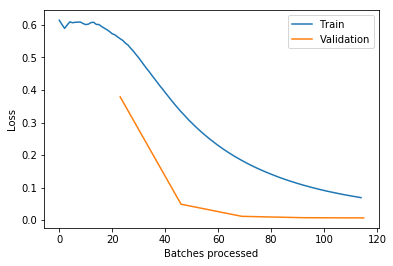

In [160]:
new_learn.recorder.plot_losses()

In [78]:
del test_learn
del new_model
del new_learn

## Setup custom model

In [222]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [223]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [224]:
#def ResizeOutput(): return Lambda(lambda x: x.view(-1))

In [225]:
drop_p = 0.0

In [226]:
# inplace=True seems to generate problems?

In [227]:
net = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [228]:
net

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.0)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.0)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [229]:
apply_init(net, nn.init.kaiming_normal_)

## Run sequence through network for testing

In [230]:
data.train_ds[0], data.train_ds[3]

((Image (1, 4, 50), MultiCategory 0), (Image (1, 4, 50), MultiCategory 1))

In [231]:
net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[ 1.9474, -0.4009]], grad_fn=<ThAddmmBackward>),
 tensor([[0.9594, 0.1754]], grad_fn=<ThAddmmBackward>))

# Learner setup

## TBLogger

In [35]:
import tensorflow as tf

# From https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
"""Simple example on how to log scalars and images to tensorboard without tensor ops.
License: Copyleft
"""
#__author__ = "Michael Gygli"

#import tensorflow as tf
#from StringIO import StringIO
#import matplotlib.pyplot as plt
#import numpy as np

class Logger(object):
    """Logging in tensorboard without tensorflow ops."""

    def __init__(self, log_dir):
        """Creates a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def log_scalar(self, tag, value, step):
        """Log a scalar variable.
        Parameter
        ----------
        tag : basestring
            Name of the scalar
        value
        step : int
            training iteration
        """
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag,
                                                     simple_value=value)])
        self.writer.add_summary(summary, step)

    def log_images(self, tag, images, step):
        """Logs a list of images."""

        im_summaries = []
        for nr, img in enumerate(images):
            # Write the image to a string
            s = StringIO()
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            im_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, nr),
                                                 image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=im_summaries)
        self.writer.add_summary(summary, step)
        

    def log_histogram(self, tag, values, step, bins=1000):
        """Logs the histogram of a list/vector of values."""
        # Convert to a numpy array
        values = np.array(values)
        
        # Create histogram using numpy        
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill fields of histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
        # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
        # Thus, we drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
        
"A `Callback` that saves tracked metrics into a log file for Tensorboard."
# Based on https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
# and devforfu: https://nbviewer.jupyter.org/gist/devforfu/ea0b3fcfe194dad323c3762492b05cae
# Contribution from MicPie

#from ..torch_core import *
#from ..basic_data import DataBunch
#from ..callback import *
#from ..basic_train import Learner, LearnerCallback
#import tensorflow as tf

__all__ = ['TBLogger']

@dataclass
class TBLogger(LearnerCallback):
    "A `LearnerCallback` that saves history of metrics while training `learn` into log files for Tensorboard."
    
    log_dir:str = 'logs'
    log_name:str = 'data'
    log_scalar:bool = True # log scalar values for Tensorboard scalar summary
    log_hist:bool = True # log values and gradients of the parameters for Tensorboard histogram summary
    log_img:bool = False # log values for Tensorboard image summary

    def __post_init__(self): 
        super().__post_init__()
    #def __init__(self):
    #    super().__init__()
        self.path = self.learn.path
        (self.path/self.log_dir).mkdir(parents=True, exist_ok=True) # setup logs directory
        self.Log = Logger(str(self.path/self.log_dir/self.log_name))
        self.epoch = 0
        self.batch = 0
        self.log_grads = {}
    
    def on_backward_end(self, **kwargs:Any):
        self.batch = self.batch+1
        #print('\nBatch: ',self.batch)
        
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                tag_grad = tag.replace('.', '/')+'/grad'
                
                if tag_grad in self.log_grads:
                    #self.log_grads[tag_grad] += value.grad.data.cpu().detach().numpy()
                    self.log_grads[tag_grad] = self.log_grads[tag_grad] + value.grad.data.cpu().detach().numpy() # gradients are summed up from every batch
                    #print('if')
                else:
                    self.log_grads[tag_grad] = value.grad.data.cpu().detach().numpy()
                    #print('else')
                
                #print(tag_grad, self.log_grads[tag_grad].sum())
        return self.log_grads
    
    #def on_step_end(self, **kwards:Any):
        #print('Step end: ', self.log_grads)

    def on_epoch_end(self, epoch:int, smooth_loss:Tensor, last_metrics:MetricsList, **kwargs:Any) -> bool:
        last_metrics = ifnone(last_metrics, [])
        tr_info = {name: stat for name, stat in zip(self.learn.recorder.names, [epoch, smooth_loss] + last_metrics)}
        self.epoch = tr_info['epoch']
        self.batch = 0 # reset batch count
        #print('\nEpoch: ',self.epoch)
        
        if self.log_scalar:
            for tag, value in tr_info.items():
                if tag == 'epoch': continue
                self.Log.log_scalar(tag, value, self.epoch+1)
                
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                
                tag = tag.replace('.', '/')
                self.Log.log_histogram(tag, value.data.cpu().numpy(), self.epoch+1)
                
                tag_grad = tag.replace('.', '/')+'/grad'
                self.Log.log_histogram(tag_grad, self.log_grads[tag_grad], self.epoch+1)
                #print(tag_grad, self.log_grads[tag_grad].sum())
                
        #if self.log_img:
        #    for tag, value in learn.model.named_parameters():
        #        
        #        tag = tag.replace('.', '/')
        #        self.Log.log_images(tag, value.data.cpu().numpy(), self.epoch+1)

## fastai learner setup

In [208]:
#learn = Learner(data, net, loss_func=nn.functional.cross_entropy, metrics=accuracy)#, callback_fns=[TBLogger])

In [232]:
def accuracy_float(input:Tensor, targs:LongTensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.type(torch.long) # convert to torch.long = int64 --> difference to accuracy metric!
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [233]:
learn = Learner(data, net, loss_func=BCEWithLogitsFlat(), metrics=accuracy_float)#, callback_fns=[TBLogger])

In [234]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Lambda               [64, 4, 50]          0          False     
______________________________________________________________________
Conv1d               [64, 32, 39]         1568       True      
______________________________________________________________________
MaxPool1d            [64, 32, 9]          0          False     
______________________________________________________________________
Lambda               [64, 288]            0          False     
______________________________________________________________________
Dropout              [64, 288]            0          False     
______________________________________________________________________
Linear               [64, 16]             4624       True      
______________________________________________________________________
ReLU                 [64, 16]             0          False     
______________________________________________________________

## fastai training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


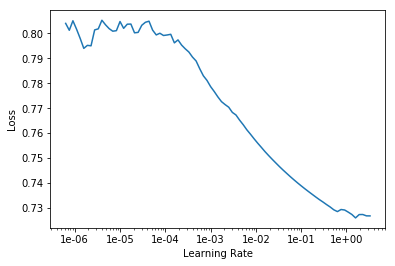

In [235]:
learn.lr_find()
learn.recorder.plot()

In [236]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_float
1,0.729492,0.694886,0.500000
2,0.707129,0.693136,0.500000
3,0.700194,0.692706,0.500000
4,0.697104,0.692436,0.500000
5,0.695544,0.692809,0.500000
6,0.694614,0.692907,0.500000
7,0.694032,0.692713,0.500000
8,0.693711,0.692530,0.500000
9,0.693478,0.692547,0.500000
10,0.693309,0.692548,0.500000


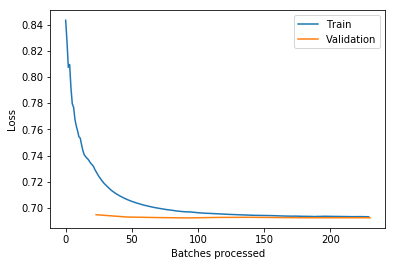

In [237]:
learn.recorder.plot_losses()

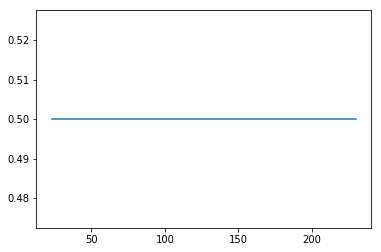

In [238]:
learn.recorder.plot_metrics()

In [239]:
learn.get_preds(DatasetType.Train)

[tensor([[0.5074, 0.4923],
         [0.5074, 0.4923],
         [0.5074, 0.4923],
         ...,
         [0.5074, 0.4923],
         [0.5074, 0.4923],
         [0.5074, 0.4923]]), tensor([[1., 0.],
         [1., 0.],
         [0., 1.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]])]

In [240]:
data.train_ds[0][1], data.train_ds[3][1]

(MultiCategory 0, MultiCategory 1)

In [155]:
#net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[-3.0462,  3.4109]], grad_fn=<ThAddmmBackward>),
 tensor([[ 2.1624, -2.5489]], grad_fn=<ThAddmmBackward>))

In [241]:
net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[ 0.0294, -0.0310]], grad_fn=<ThAddmmBackward>),
 tensor([[ 0.0294, -0.0310]], grad_fn=<ThAddmmBackward>))

In [242]:
preds, targs = learn.get_preds()

In [243]:
#targs.view(-1,1)

In [244]:
#preds

In [245]:
i = 0
preds[i], targs[i]

(tensor([0.5074, 0.4923]), tensor([1., 0.]))

In [246]:
data.train_ds[0], data.train_ds[3]

((Image (1, 4, 50), MultiCategory 0), (Image (1, 4, 50), MultiCategory 1))

In [247]:
learn.predict(data.train_ds[0][0]), learn.predict(data.train_ds[3][0])

((MultiCategory 0, tensor([1., 0.]), tensor([0.5074, 0.4923])),
 (MultiCategory 0, tensor([1., 0.]), tensor([0.5074, 0.4923])))

In [125]:
#learn.save('v6')

In [126]:
#learn.load('v6')

In [127]:
interpret = ClassificationInterpretation.from_learner(learn)

In [128]:
interpret.confusion_matrix()

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'other'

In [130]:
#interpret.plot_confusion_matrix()

## Basic PyTorch

In [132]:
def seq2array(seq:str)->List:
    "Return `List` object with np.array created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    return enc

In [133]:
# test open sequence image function
test_arr = seq2array('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC'); test_arr, test_arr.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

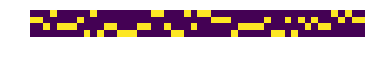

In [135]:
plt.imshow(test_arr)
plt.axis('off');

In [136]:
test_ten = tensor(test_arr).view(1,4,50).type(torch.float); test_ten

tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
          0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
          1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
          1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
          0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [138]:
net(test_ten)

tensor([[0.5792, 0.8873]], grad_fn=<ThAddmmBackward>)

In [139]:
#x = [seq2array(s) for s in seq_df['Sequences'].values]
x = [tensor(seq2array(s)).view(1,4,50).type(torch.float) for s in seq_df['Sequences'].values]

In [140]:
x = torch.stack(x) # convert list to tensor

In [141]:
y = tensor(targ).type(torch.float)

In [142]:
len(x), len(y)

(2000, 2000)

In [143]:
i = 2
x[i], y[i]

(tensor([[[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
           1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
           1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
           0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]]),
 tensor([0., 1.]))

In [144]:
#train_ds = TensorDataset(*map(tensor, (x[:1500],y[:1500])))
#valid_ds = TensorDataset(*map(tensor, (x[-500:],y[-500:])))

In [145]:
train_ds = TensorDataset(x[:1500],y[:1500])
valid_ds = TensorDataset(x[-500:],y[-500:])

In [146]:
len(train_ds), len(valid_ds)

(1500, 500)

In [147]:
bs = 64

In [148]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)

In [149]:
opt = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [150]:
# From https://github.com/fastai/fastai_docs/blob/master/dev_nb/mnist_sample.py

def simple_loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def simple_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: simple_loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[simple_loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

In [151]:
simple_fit(50, net, F.binary_cross_entropy_with_logits, opt, train_dl, valid_dl)

0 0.7190498490333557
1 0.7050352506637573
2 0.6961764173507691
3 0.6908255777359009
4 0.6867873430252075
5 0.6830001063346863
6 0.6790869107246399
7 0.6749651308059692
8 0.6698150882720947
9 0.6644322867393494
10 0.6579435110092163
11 0.6502404742240906
12 0.6416972894668579
13 0.6332809867858886
14 0.6231716270446778
15 0.6134686875343323
16 0.6028455514907837
17 0.5911505107879639
18 0.5798500070571899
19 0.5681980724334716
20 0.5569746432304382
21 0.5441656274795532
22 0.5315023617744445
23 0.5198882250785828
24 0.5071483170986175
25 0.495280757188797
26 0.48363769602775575
27 0.47291108465194703
28 0.46254910588264464
29 0.45185568833351136
30 0.44211202335357663
31 0.43252268314361575
32 0.4244113097190857
33 0.41471190929412843
34 0.4061092174053192
35 0.39786021900177004
36 0.3902950119972229
37 0.38145887160301206
38 0.37416774916648865
39 0.36616297721862795
40 0.35930802249908445
41 0.3521958405971527
42 0.3449663071632385
43 0.3373350877761841
44 0.3324274506568909
45 0.3270

In [162]:
data.train_ds[0][1], data.train_ds[3][1]

(MultiCategory 0;1, MultiCategory 1;0)

In [152]:
net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[-3.0462,  3.4109]], grad_fn=<ThAddmmBackward>),
 tensor([[ 2.1624, -2.5489]], grad_fn=<ThAddmmBackward>))

# Check fastai dataloader

In [159]:
data.train_ds.y[0]

MultiCategory 0;1

In [172]:
next(iter(data.train_dl))

[tensor([[[[0., 1., 1.,  ..., 0., 1., 0.],
           [0., 0., 0.,  ..., 1., 0., 1.],
           [1., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 1., 0., 1.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 1., 0.]]],
 
 
         ...,
 
 
         [[[0., 1., 0.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 0., 1., 0.],
           [0., 0., 0.,  ..., 1., 0., 1.],
           [0., 0., 1.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 1., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [1., 0., 0.,  ..., 0., 0., 1.],
           [0., 0., 1.,  ..., 1., 1., 0.]]],
 
 
         [[[0., 1., 0.,  ..., 0., 0., 1.],
           [0., 0., 0.,  ..., 1., 0., 0.],
      